# Ma formation : Opencv 

## import package

In [1]:
from asyncio import threads
from pickletools import uint8
import cv2
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt

## Functions

In [2]:
def getPerspective(img,location,height = 900, width = 900):
    cornersOg = np.float32([location[0], location[3], location[1], location[2]])
    cornersFlattened = np.float32([[0, 0], [width, 0], [0, height], [width, height]])
    transformMatrix = cv2.getPerspectiveTransform(cornersOg,cornersFlattened)
    result = cv2.warpPerspective(img,transformMatrix,(width,height))
    return result

In [3]:
#Create the webcam object using the default cam (0)

MNIST_model = tf.keras.models.load_model('saved_model/MNIST')


In [4]:
MNIST_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 64)                50240     
                                                                 
 dense_1 (Dense)             (None, 10)                650       
                                                                 
Total params: 50,890
Trainable params: 50,890
Non-trainable params: 0
_________________________________________________________________


In [14]:
while True:
    #Fetch the data from the feed
    cam = cv2.VideoCapture(0)
    [ret,image] = cam.read()
    if not ret:
        raise IOError("No image fetched")
    gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    blur = cv2.GaussianBlur(gray,(5,5),4)
    thresh = cv2.adaptiveThreshold(blur,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY_INV,9,1)
    contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    #cv2.drawContours(image,contours,-1,(0,255,0),2)
    mask = None
    for i,contour in enumerate(contours):
        area = cv2.contourArea(contour)
        if area>10000:
            #print(area)
            approx = 0
            approx = cv2.approxPolyDP(contour,0.01*cv2.arcLength(contour,True),True)
            if len(approx == 4):
                mask = np.zeros(gray.shape,np.uint8)
                cv2.drawContours(image,contours,i,(255,0,0),2)
                cv2.drawContours(mask,contours,i,255,-1)
                cv2.drawContours(mask,contours,i,0,2)
                out = np.zeros_like(gray)
                out[mask==255] = gray[mask==255]
                blur = cv2.GaussianBlur(out,(3,3),1)
                newTresh = cv2.adaptiveThreshold(blur,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY_INV,9,5)
                gridContours, gridHierarchy = cv2.findContours(newTresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
                flatImage = getPerspective(gray,approx)
                flatImageBlur = cv2.GaussianBlur(flatImage,(5,5),1)
                flatImageTresh = cv2.adaptiveThreshold(flatImageBlur,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY_INV,9,3)
                lines = cv2.HoughLinesP(flatImageTresh,1,np.pi/90,100,10)
                if lines is not None:
                    print(len(lines))
                    for points in lines:
                        # Extracted points nested in the list
                        x1,y1,x2,y2=points[0]
                        # Draw the lines joing the points
                        # On the original image
                        cv2.line(flatImage,(x1,y1),(x2,y2),(0,255,255),2)
                cv2.imshow("Isolated",flatImageTresh)
                #cv2.imshow("Lines",flatImage)
            break
            
    cv2.imshow('Webcam',image)
    #Exit pressing 'ESC'
    c = cv2.waitKey(1)
    if c == 27:
        break

cam.release()
cv2.destroyAllWindows()


328
238
112
544
852
853
732
505
192
786
690
95
789
735
723
740
805
768


(28, 28)


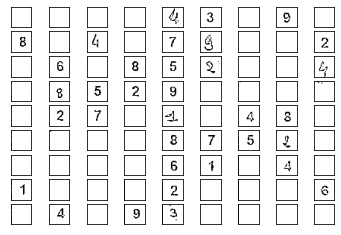

In [37]:
sudoku = np.zeros((9,9),np.int8)
allInput = []
for idx, x in np.ndenumerate(sudoku):
    #print(idx)
    i = idx[0]
    j = idx[1]
    #cellImage = np.zeros((100,100),np.uint8)
    cellImage = flatImageTresh[i*100+5:i*100+90,j*100+5:j*100+90]
    #cellImageBlur = cv2.GaussianBlur(cellImage,(5,5),1)
    #cellImageTresh = cv2.adaptiveThreshold(cellImageBlur,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,9,3)
    cv2.imshow('Current cellImage',cellImage)
    #cv2.imshow('Current cellImageBlur',cellImageBlur)
    #cv2.imshow('Current cellImageTresh',cellImageTresh)
    #print(cellImage.shape()) 
    inputCV2 = cv2.resize(cellImage,(28,28))
    input = np.zeros((28,28),np.float32)
    input[inputCV2 == 255] = 255
    plt.subplot(9,9,i*9+j+1)
    #plt.imshow(input,cmap=plt.cm.binary)
    inputInverted = np.ones((28,28),np.float32)
    inputInverted[input == 1] = 0
    plt.imshow(input,cmap=plt.cm.binary)

    plt.xticks([])
    plt.yticks([])
    #allInput = [allInput,input]
    allInput.append(input)
print(input.shape)
plt.show()


In [38]:
arg = tf.convert_to_tensor(allInput)
probability_model = tf.keras.Sequential([MNIST_model,tf.keras.layers.Softmax()])
predictions = probability_model.predict(arg)

3/3 [==============================] - 0s 1ms/step


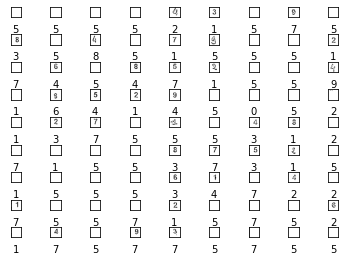

In [39]:
for i in range(len(predictions)):
    res = np.argmax(predictions[i])
    #print(i," : ",res)
    plt.subplot(9,9,i+1)
    plt.imshow(allInput[i],cmap=plt.cm.binary)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(res)
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=1.7)
plt.show()
